# Imports

In [3]:
from sksurv.metrics          import concordance_index_censored, concordance_index_ipcw
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors       import LinearSegmentedColormap
from skimage.transform       import resize
from plottify                import autosize
from sklearn                 import metrics
from PIL                     import Image
from adjustText              import adjust_text
from scipy.cluster           import hierarchy
from lifelines 				 import CoxPHFitter
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import pandas            as pd
import scanpy            as sc
import scipy.stats
import matplotlib
import anndata
import random
import fastcluster
import sklearn
import copy
import umap
import h5py
import shap
import sys
import os

# Workspace path.
main_path = '/raid/users/farzaneh/Histomorphological-Phenotype-Learning/'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
from models.visualization.survival import save_fold_KMs
from models.visualization.forest_plots import report_forest_plot_cph, summary_cox_forest_plots
from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.visualization.attention_maps import *
from models.clustering.data_processing import *
from data_manipulation.data import Data
import warnings
warnings.filterwarnings("ignore")


# Plot figures

In [26]:
def plot_performance_cindex(all_data, title='Leiden + Logistic Regression'):
	meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":"6"}
	sns.set_theme(style='white')
	ylim = (0.4, 1.0)
	fig   = plt.figure(figsize=(10,5))
	ax    = fig.add_subplot(1, 1, 1)
	sns.pointplot(x='Leiden', hue='Set', y='C-Index', data=all_data, ax=ax, dodge=.4, join=False, capsize=.02, markers='o')
	if ylim is not None:
		ax.set_ylim(ylim)
	ax.set_title(title, fontweight='bold', fontsize=18)
	ax.legend(loc='upper left')
	ax.axhline(y=0.75)
	ax.axhline(y=0.6)
	plt.show()

# Plot SHAP figure.
def plot_shap_figure(shap_cv, order, total_order, text1, text2, plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=150, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True)):
	text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

	sns.set_theme(style='white')
	shap.plots.beeswarm(shap_cv, max_display=len(order)+1, order=total_order,
						color_bar_label='Histomorpholical Phenotype Cluster (HPC)\n Contribution',
						color=cmap_bar, plot_size=plot_size, show=False)
	figure = plt.gcf()
	figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
	figure.axes[1].set_ylabel('Histomorpholical Phenotype Cluster (HPC)\n Contribution', fontweight='bold', fontsize=fontsize_labels)
	for ax in [figure.axes[0], figure.axes[1]]:
		for tick in ax.xaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for tick in ax.yaxis.get_major_ticks():
			tick.label1.set_fontweight('bold')
			tick.label2.set_fontweight('bold')
			tick.label1.set_fontsize(fontsize_ticks)
			tick.label2.set_fontsize(fontsize_ticks)
		for axis in ['top','bottom','left','right']:
			ax.spines[axis].set_linewidth(4)
	plt.show()

def plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None):

    if low_risk_ind is None:
        risk_ind = high_risk_ind
    elif high_risk_ind is None:
        risk_ind = low_risk_ind
    else:
        risk_ind = np.concatenate([low_risk_ind.values, high_risk_ind.values])

    # Legend handling.
    if show_legend:
        legend_labels = ['Low Risk' for s in range(low_risk_ind.values.shape[0])]
        legend_labels.extend(['High Risk' for s in range(high_risk_ind.values.shape[0])])
    else:
        legend_labels = None
    # Number of HPCs to display
    if num_features == 'all':
        feature_display_range = slice(None, None, -1)
    else:
        feature_display_range = slice(-1, -num_features, -1)

    shap_base_plot = [shap_base_values[risk_ind[0]]]
    shap_cv_values = np.array(shap_cv.values[risk_ind[0]].reshape((1,-1)))
    data_values    = np.array(dataset_samples_features.loc[risk_ind[0]].values.reshape((1,-1)))

    for ind in risk_ind[1:]:        
        shap_base_plot.append(shap_base_values[ind])
        shap_cv_values = np.concatenate([shap_cv_values, shap_cv.values[ind].reshape((1,-1))])
        data_values    = np.concatenate([data_values, dataset_samples_features.loc[ind].values.reshape((1,-1))])

    # SHAP decision plot.
    shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, features=dataset_samples_features.loc[risk_ind], xlim=xlim,
                    feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')

    # Ascetic fixes.
    figure = plt.gcf()
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    figure.axes[0].set_ylabel('Histomorpholical Phenotype Cluster (HPC)', fontweight='bold', fontsize=fontsize_labels)
    for ax in [figure.axes[0]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
        for axis in ['bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
    
    # Legend for High/Low risk group.
    if show_legend:
        legend = figure.axes[0].legend_
        new_handles = [legend.legendHandles[0], legend.legendHandles[-1]]
        new_texts   = [legend.get_texts()[0]._text, legend.get_texts()[-1]._text]
        map_dict = dict()
        for handle, text in zip(legend.legendHandles, legend.get_texts()):
            map_dict[handle._label] = text._text

        legend.remove()
        legend = figure.axes[0].legend(new_handles, new_texts, loc='lower right')
        legend.get_frame().set_linewidth(l_box_w)
        for i, handler in enumerate(legend.legendHandles):
            handler.set_linewidth(5)
            handler.set_color('Blue')
            if i!=0:
                handler.set_color('Red')

        for text in legend.get_texts():
            text.set_size(fontsize_legend)
            text.set_fontweight('bold')

        # Re-color lines for High/Low risk group.
        continuous_lines = [child for child in figure.axes[0]._children if child._linestyle == '-' and len(child._x) > 2]
        i = 0 
        for child in continuous_lines:
            risk_name = map_dict[child._label]
            if risk_name == 'Low Risk':
                child.set_color('Blue')
            elif risk_name == 'High Risk':
                child.set_color('Red')
            i+=1
    else:
        annotations_val  = [child for child in figure.axes[0]._children if not isinstance(child, matplotlib.lines.Line2D)]
        for child in annotations_val:
            orig_fontsize = child._fontproperties._size
            child.set_fontweight('bold')
            child.set_size(orig_fontsize*1.1)

    plt.show()

    global_xlim = figure.axes[0].get_xlim()
    return global_xlim


# Lung Type Classification Modeling

## Variables

In [7]:
############# Lungsubtype
# meta_field        = 'luad'
# matching_field    = 'slides'
# resolution       = 2.0
# fold_number      = 4
# groupby          = 'leiden_%s' % resolution
# meta_folder      = 'lungsubtype_nn250'
# folds_pickle     = '/media/adalberto/Disk2/PhD_Workspace/utilities/files/LUADLUSC/lungsubtype_Institutions.pkl'
# type_composition = 'clr'
# min_tiles        = 100

############# mesosubtype
meta_field = 'Meso_type'
matching_field = 'slides'
resolution     = 2.0
fold_number    = 0
groupby        = 'leiden_%s' % resolution
meta_folder    = 'meso_nn250'
folds_pickle   = '%s/files/pkl_Meso_250_subsampled_he_complete.pkl'%main_path
type_composition = 'clr'
additional_as_fold = False
min_tiles        = 100

# Representations.
h5_complete_path = '%s/results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/hdf5_Meso_250_subsampled_he_complete_combined_metadata_filtered.h5'%main_path
# h5_additional_path = None
h5_additional_path = h5_complete_path

# File name and directories.
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
if h5_additional_path is not None: file_additional = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figures_path      = os.path.join(main_cluster_path, 'figures')
if not os.path.isdir(figures_path):
	os.makedirs(figures_path)

## Read 5-fold cross-validation data

In [8]:
# Get folds from existing split.
folds = load_existing_split(folds_pickle)

# Path for alpha Logistic Regression results.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

data_res_folds = dict()
data_res_folds[resolution] = dict()
for i, fold in enumerate(folds):
	# Read CSV files for train, validation, test, and additional sets.
	dataframes, complete_df, leiden_clusters = read_csvs(adatas_path, matching_field, groupby, i, fold, h5_complete_path, h5_additional_path, additional_as_fold=False, force_fold=fold_number)
	train_df, valid_df, test_df, additional_df = dataframes

	# Check clusters and diversity within.
	frame_clusters, frame_samples = create_frames(train_df, groupby, meta_field, diversity_key=matching_field, reduction=2)

	# Create representations per sample: cluster % of total sample.
	data, data_df, features = prepare_data_classes(dataframes, matching_field, meta_field, groupby, leiden_clusters, type_composition, min_tiles,
												   use_conn=False, use_ratio=False, top_variance_feat=0)

	# Include features that are not the regular leiden clusters.
	frame_clusters = include_features_frame_clusters(frame_clusters, leiden_clusters, features, groupby)

	# Store representations.
	data_res_folds[resolution][i] = {'data':data, 'data_df':data_df, 'complete_df':complete_df, 'features':features, 'frame_clusters':frame_clusters, 'leiden_clusters':leiden_clusters}

	# Information.
	print('\t\tFold', i, 'Features:', len(features), 'Clusters:', len(leiden_clusters))

Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv
		Fold 0 Features: 45 Clusters: 45
Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Pheno

## Run 5-fold cross-validation

In [9]:
def model_log_odds(x):
	p = model.predict_log_proba(x)
	return p[:,1] - p[:,0]

# Cross-validation data.
test_samples        = list()
shap_values_cv      = list()
shap_base_values_cv = list()
shap_data_cv		= list()
coefficients         = list()
for i, fold in enumerate(folds):
	
	# Load data for classification.
	data_df         = data_res_folds[resolution][i]['data_df']
	features        = data_res_folds[resolution][i]['features']
	leiden_clusters = data_res_folds[resolution][i]['leiden_clusters']

	train_df, valid_df, test_df, additional_df = data_df

	# a simple linear model
	model = sklearn.linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=100000)
	model.fit(train_df[leiden_clusters], train_df[meta_field])
	coefficients.append(model.coef_)

	complete_df = pd.concat([test_df], axis=0)
	data_plot = complete_df[leiden_clusters.tolist()]
	data_plot.columns = data_plot.columns.astype(str)

	explainer = shap.Explainer(model_log_odds, train_df[leiden_clusters.tolist()], max_samples=train_df.shape[0])
	shap_values = explainer(data_plot)
	shap_values_cv.append(shap_values.values)
	shap_base_values_cv.append(shap_values.base_values)
	shap_data_cv.append(shap_values.data)
	test_samples.append(data_plot)

# Combine SHAP values for 5-fold test set.
dataset_samples         = test_samples[0].copy(deep=True)
shap_values_cv_all      = np.array(shap_values_cv[0])
shap_base_values_cv_all = np.array(shap_base_values_cv[0])
shap_data_cv_all        = np.array(shap_data_cv[0])
for i in range(1, len(shap_values_cv)):
	dataset_samples = pd.concat([dataset_samples, test_samples[i]], axis=0)
	shap_values_cv_all      = np.concatenate([shap_values_cv_all, shap_values_cv[i]], axis=0)
	shap_base_values_cv_all = np.concatenate([shap_base_values_cv_all, shap_base_values_cv[i]], axis=0)
	shap_data_cv_all        = np.concatenate([shap_data_cv_all, shap_data_cv[i]], axis=0)

# SHAP object.
shap_cv             = copy.deepcopy(shap_values)
shap_cv.values      = shap_values_cv_all
shap_cv.base_values = shap_base_values_cv_all
shap_cv.data        = shap_data_cv_all

# Coefficients 5-fold cross-validation.
coefficients = np.mean(np.array(coefficients), axis=0)
coefficients = pd.DataFrame(coefficients.T, columns=['coef'])
coefficients[groupby] = list(range(coefficients.shape[0]))
coef_folds_pos = coefficients[coefficients['coef']>0]
coef_folds_neg = coefficients[coefficients['coef']<0]
hpc_pos = coef_folds_pos[groupby].values
hpc_neg = coef_folds_neg[groupby].values

Permutation explainer: 242it [00:12,  4.61it/s]                                                                             
Permutation explainer: 253it [00:11,  3.20it/s]                                                                             
Permutation explainer: 266it [00:12,  3.68it/s]                                                                             


In [19]:
pd.DataFrame(data_df[0])

,slides,0,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,43,44,Meso_type
0,MESO_38_13,4.885095,1.100905,2.199518,-1.866767,1.794053,-1.866767,-1.866767,2.353668,1.100905,...,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,2.199518,-1.866767,0
1,MESO_464_9,-1.374139,3.264759,2.309248,-1.374139,0.699810,-1.374139,-1.374139,2.086104,3.264759,...,-1.374139,-1.374139,-1.374139,-1.374139,0.699810,-1.374139,-1.374139,-1.374139,-1.374139,0
2,MESO_475_4,2.024861,1.783699,0.078950,-0.614197,0.772098,0.995241,-2.569089,0.772098,0.484416,...,-2.569089,-2.569089,1.783699,-2.569089,2.024861,-2.569089,-2.569089,-2.569089,-2.569089,1
3,MESO_60_17,2.299119,0.689681,-2.126226,1.788294,2.075976,2.299119,4.539829,2.481441,-2.126226,...,-2.126226,2.075976,-2.126226,-2.126226,-2.126226,1.382828,2.635591,-2.126226,-2.126226,0
4,MESO_3_19,2.565248,2.908193,1.083644,2.609700,-0.525794,1.776791,1.083644,1.420116,-2.731491,...,-2.731491,-0.525794,-2.731491,-2.731491,-0.525794,-2.731491,-2.731491,-2.731491,-2.731491,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,MESO_65_11,2.529074,3.302264,-1.709796,3.135210,2.123609,2.346753,-1.709796,2.683225,-1.709796,...,-1.709796,-1.709796,-1.709796,-1.709796,-1.709796,-1.709796,-1.709796,-1.709796,-1.709796,0
1268,MESO_6_12,-2.063432,1.923061,0.418984,2.861331,2.123732,3.554478,-2.063432,1.671747,-2.063432,...,0.824449,-2.063432,-2.063432,-2.063432,-2.063432,-2.063432,-2.063432,-2.063432,-2.063432,0
1269,MESO_484_10(2),-1.849387,1.577128,-1.849387,-1.849387,-1.849387,3.592031,-1.849387,2.493419,-1.849387,...,3.592031,-1.849387,2.270275,3.774353,-1.849387,-1.849387,-1.849387,-1.849387,-1.849387,1
1270,MESO_59_14,-2.307919,-2.307919,2.152325,1.641499,1.641499,1.641499,2.740112,2.740112,0.542887,...,-2.307919,0.542887,-2.307919,0.542887,0.542887,-2.307919,-2.307919,-2.307919,-2.307919,0


# Shap figures

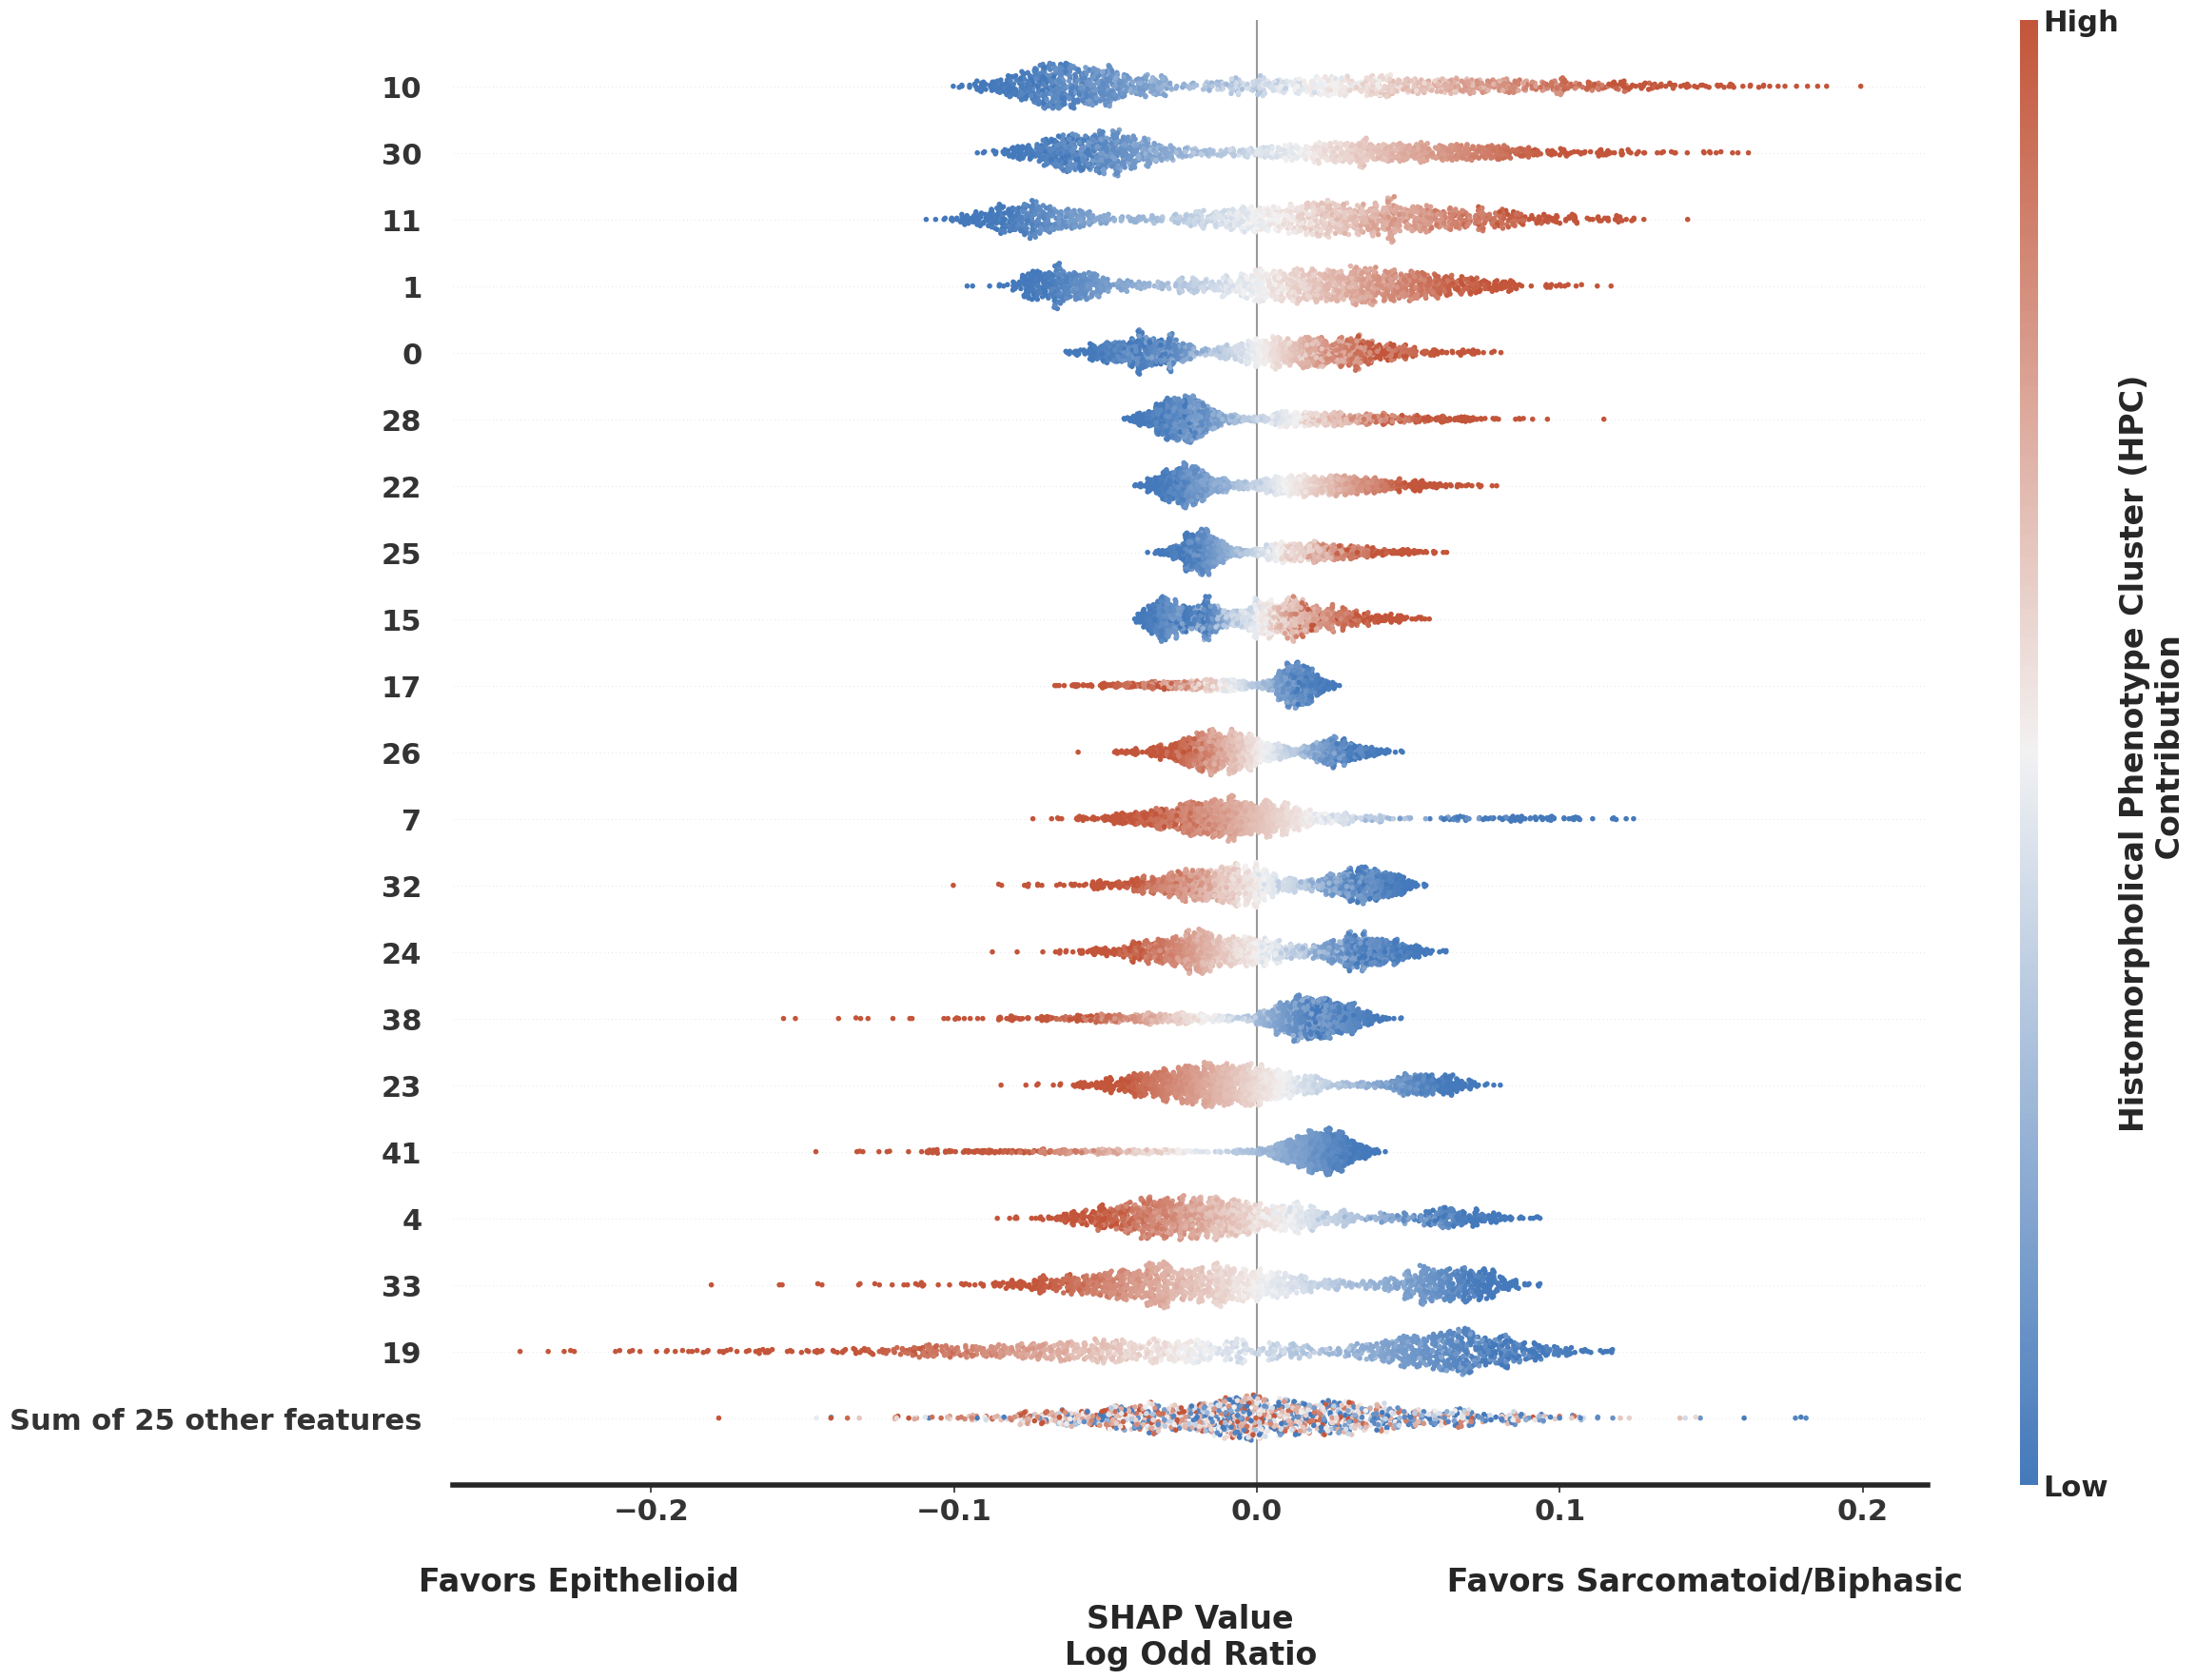

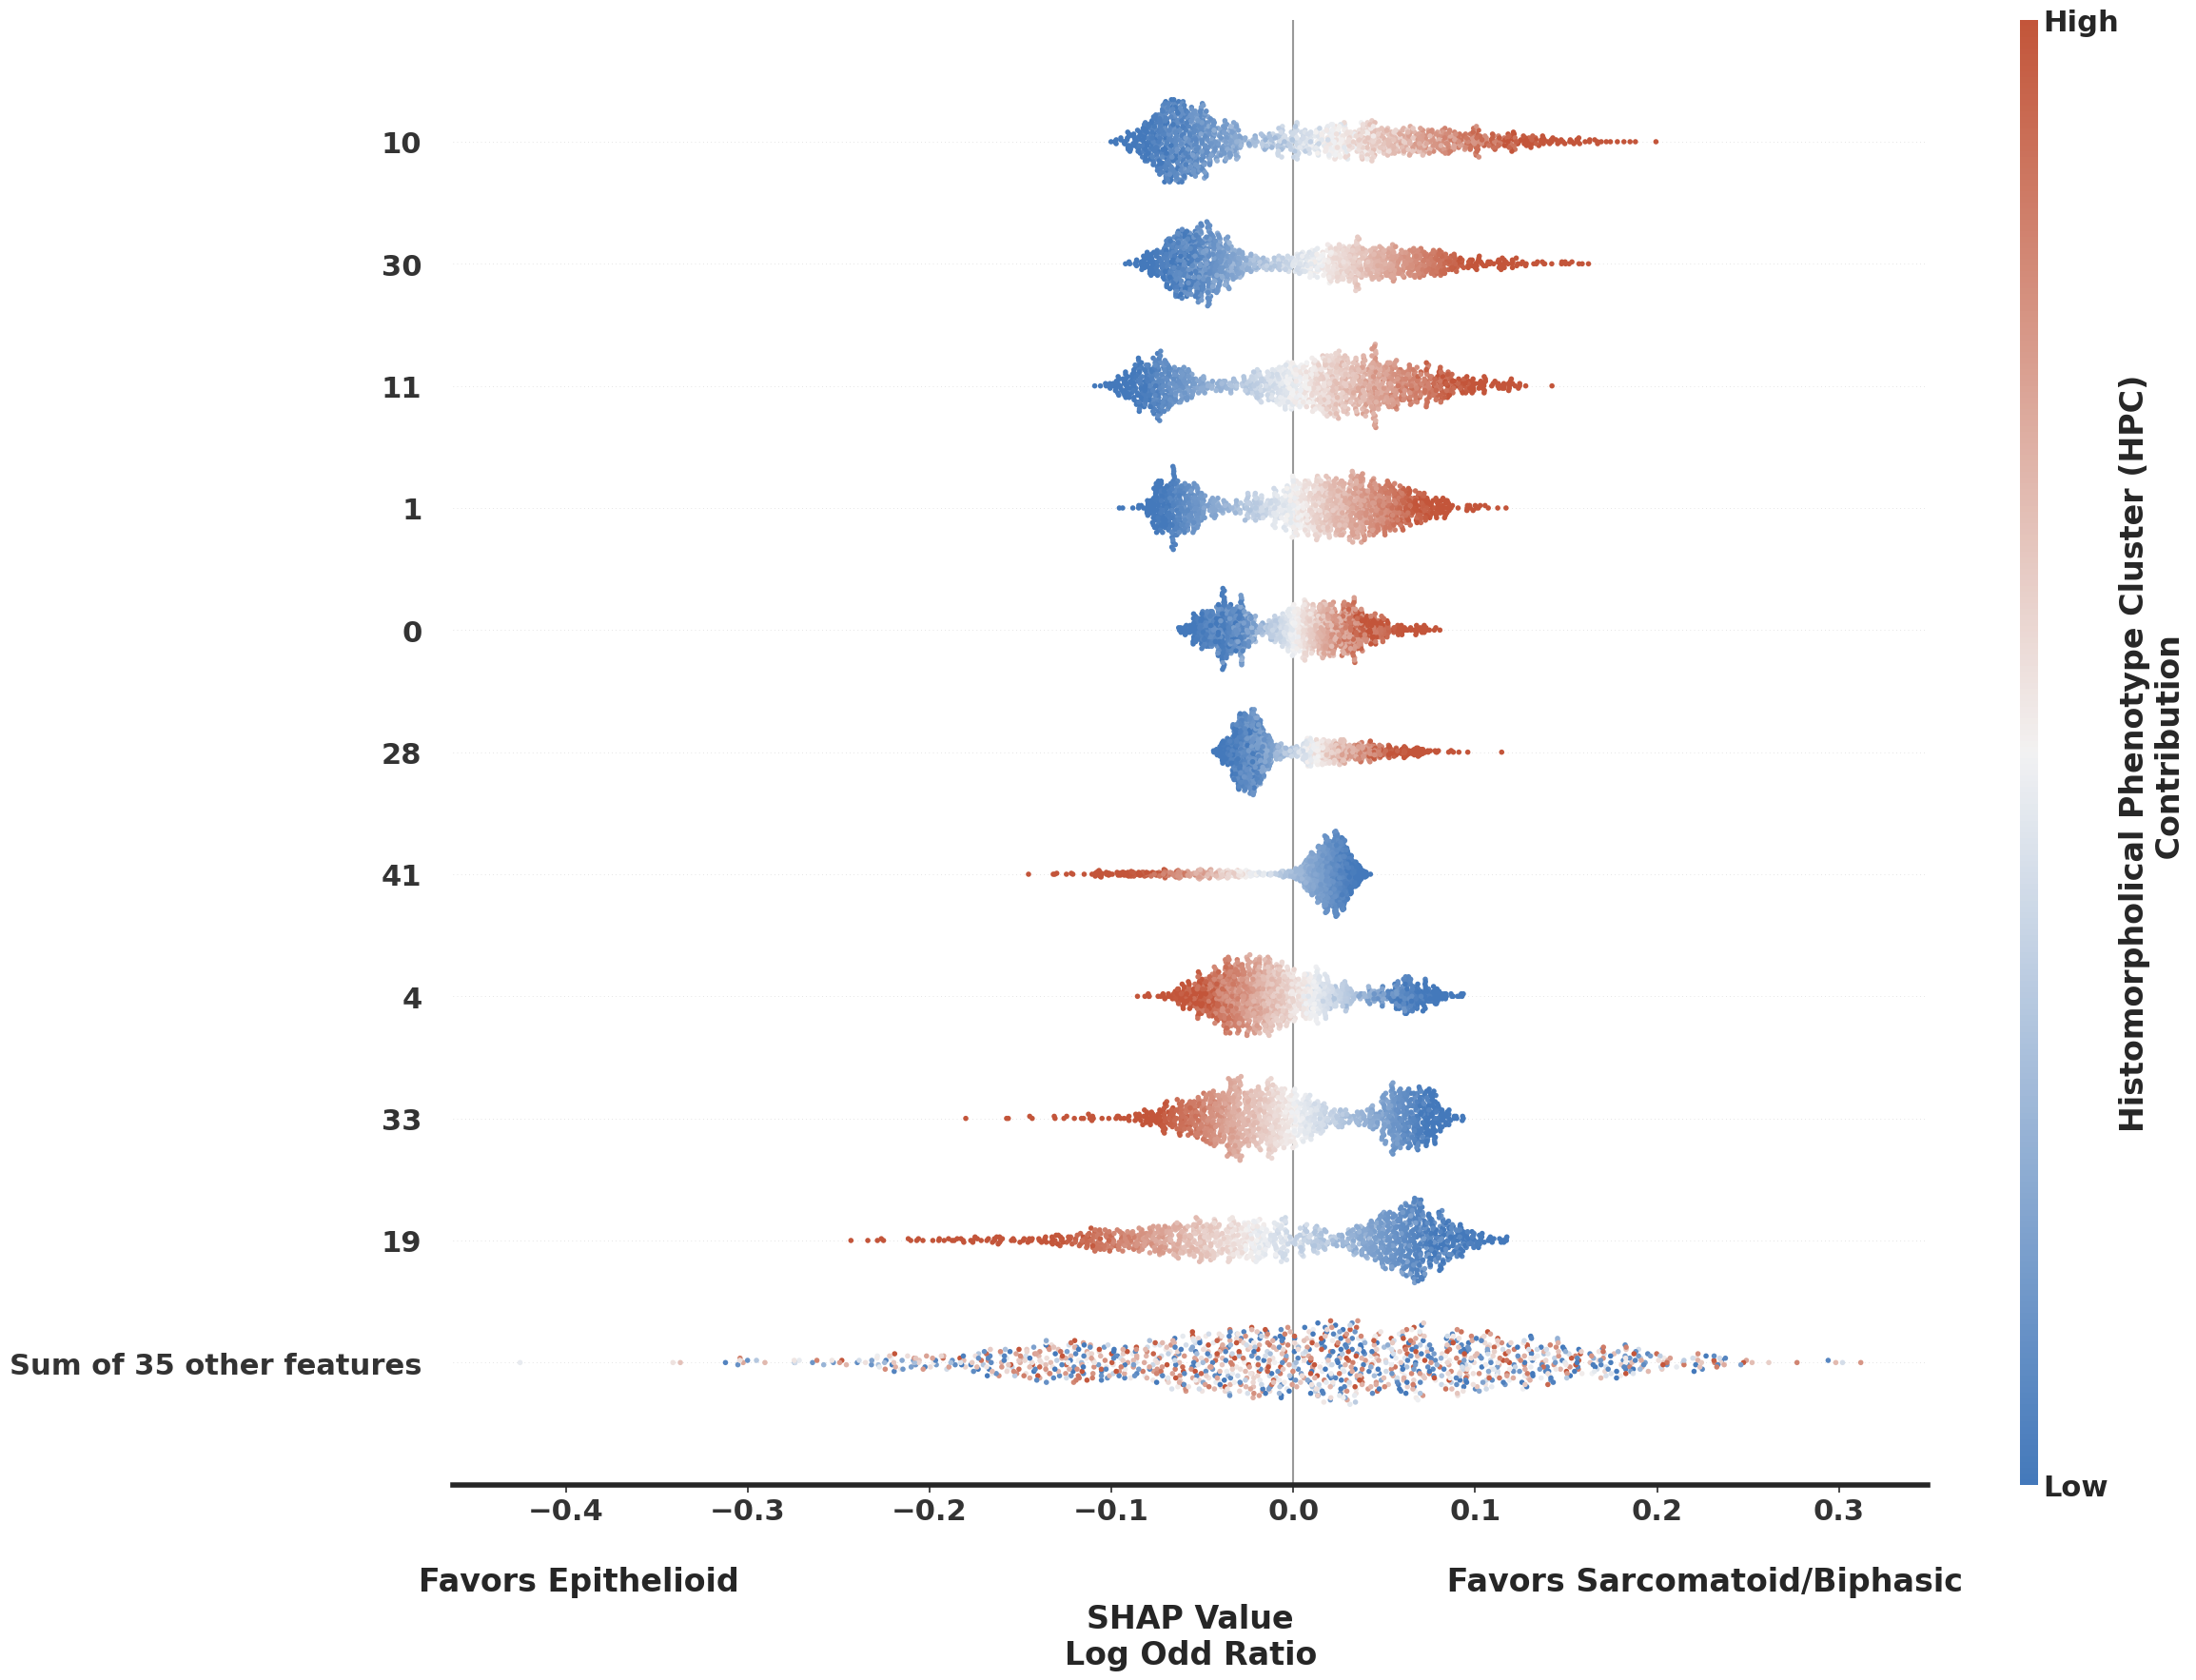

In [27]:
def remove_features_from_shap(shap_cv, features_to_remove):
	shap_cv_removed = copy.deepcopy(shap_cv)
	for feature in features_to_remove:
		shap_cv_removed.values[:,feature] = 0
		shap_cv_removed.data[:,feature] = 0
	return shap_cv_removed

for hpc_samples in [20, 10]:
	# Get order to display:
	# 1. Pro/Against event: Cox coefficient sign.
	# 2. Average absolute effect on the cohort: SHAP.
	# Select top X HPC impact for Pro/Against.
	hpc_impact = list(reversed(np.argsort(shap_cv.abs.mean(0).values)))
	pos_order = list()
	neg_order = list()
	for hpc in hpc_impact:
		if hpc in hpc_pos and len(pos_order+neg_order) < hpc_samples:
			pos_order.append(hpc)
		elif hpc in hpc_neg and len(pos_order+neg_order) < hpc_samples:
			neg_order.append(hpc)
	order = pos_order + list(reversed(neg_order))
	difference = list(set(features).difference(set(order)))
	total_order = order + list(difference)

	# Remove the features that are not going to be plotted for ascetics.
	shap_cv_removed = remove_features_from_shap(shap_cv=shap_cv, features_to_remove=difference)

	# Shap figure.
	text1 = '\nFavors Epithelioid'
	text2 = 'Favors Sarcomatoid/Biphasic\nSHAP Value\nLog Odd Ratio'
	plot_shap_figure(shap_cv, order, total_order, text1, text2, plot_size=(25,20), fontsize_labels=24, fontsize_ticks=22, offset=135, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True))

# Cox Survival Modeling

## Variables

In [21]:
# Common variables.
# type_composition = 'clr'
max_months       = 15.0*15.0
# matching_field    = 'samples'
diversity_key    = None

# Representation files.
# h5_complete_path   = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered.h5' % main_path
# h5_additional_path = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/NYU300LUAD_Survival_5x_60pc/h224_w224_n3_zdim128/hdf5_NYU300LUAD_Survival_5x_60pc_he_train_overall_progression_free_surival_filtered.h5' % main_path

# Cluster configuration details.
resolution = 2.0
force_fold  = 0

# PFS related variables.
event_ind_field  = 'os_event_ind'
event_data_field = 'os_event_data'
# additional_as_fold = True
# meta_folder        = 'luad_progression_free_survival_nn250_fold0_NYU_v3_csNP'
# folds_pickle       = '%s/utilities/files/LUAD/progression_free_survival_NYU_folds_v3_csNP.pkl' % main_path

# OS related variables.
# event_ind_field     = 'os_event_ind'
# event_data_field    = 'os_event_data'
# additional_as_fold = False
# meta_folder        = 'luad_overall_survival_nn250_fold0_NYU_v3'
# folds_pickle       = '%s/utilities/files/LUAD/overall_survival_TCGA_folds.pkl'  % main_path

## Read 5-fold cross-validation data

In [23]:
# Setup folder.
h5_additional_path = h5_complete_path

main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

# Get folds from existing split.
folds = load_existing_split(folds_pickle)

# If diversity key is not specified, use the key that represents samples.
if diversity_key is None:
	diversity_key = matching_field

# Loading data first.
print('Loading data:')
data_res_folds = dict()
groupby = 'leiden_%s' % resolution
print('\tResolution', groupby)
data_res_folds[resolution] = dict()
for i, fold in enumerate(folds):
	# Read CSV files for train, validation, test, and additional sets.
	dataframes, complete_df, leiden_clusters = read_csvs(adatas_path, matching_field, groupby, i, fold, h5_complete_path, h5_additional_path, additional_as_fold, force_fold)

	# Check clusters and diversity within.
	frame_clusters, frame_samples = create_frames(complete_df, groupby, event_ind_field, diversity_key=matching_field, reduction=2)

	# Prepare data for COX.
	data, datas_all, features = prepare_data_survival(dataframes, groupby, leiden_clusters, type_composition, max_months, matching_field, event_ind_field, event_data_field, 100, use_conn=False, use_ratio=False, top_variance_feat=0, remove_clusters=None)
	if i==0:
		data_percent, datas_all_percent, _ = prepare_data_survival(dataframes, groupby, leiden_clusters, 'percent', max_months, matching_field, event_ind_field, event_data_field, 100, use_conn=False, use_ratio=False, top_variance_feat=0, remove_clusters=None)

	# Store representations.
	data_res_folds[resolution][i] = {'data':data, 'data_all':datas_all, 'features':features, 'frame_clusters': frame_clusters}

	# Information
	print('\t\tFold', i, 'Features:', len(features), 'Clusters:', len(leiden_clusters))

Loading data:
	Resolution leiden_2.0
Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning//results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv
train df info: (444123, 15)
valid df info: (74878, 15)
test df info: (85649, 15)
additional df info: (444123, 15)
event_data_field: os_event_data
valid_slides_df info after set survival: (1265, 48)
additional_slides_df info after set survival: (1265, 48)
train df info: (444123, 15)
valid df info: (74878, 15)
test df info: (85649, 15)
additional df info: (444123, 15)
event_data_field: os_ev

## Run 5-fold cross-validation

In [24]:
l1_ratio = 0.0
if 'os_' in event_data_field:
	alpha    = 1.
else:
	alpha    = 0.27

# Cross-validation data.
test_samples        = list()
shap_values_cv      = list()
shap_base_values_cv = list()
shap_data_cv		= list()

data_all = pd.concat([datas_all[0][0], datas_all[2][0]], axis=0)

groupby = 'leiden_%s' % resolution
folds_cis = list()
models    = list()
cox_folds = list()

risk_groups     = [pd.DataFrame(), pd.DataFrame()]
additional_risk = pd.DataFrame()
num_folds = len(data_res_folds[resolution].keys())
for fold_cox in range(num_folds):
	# Load data.
	datas     = data_res_folds[resolution][fold_cox]['data']
	datas_all = data_res_folds[resolution][fold_cox]['data_all']
	features  = data_res_folds[resolution][fold_cox]['features']
	frame_clusters = data_res_folds[resolution][fold_cox]['frame_clusters']
	train, set_name   = datas[0]
	test, set_name    = datas[2]
	test_df, set_name = datas_all[2]

	# Train Cox Proportional Hazard.
	cph = CoxPHFitter(penalizer=alpha, l1_ratio=l1_ratio)
	cph.fit(train[features+[event_data_field, event_ind_field]], duration_col=event_data_field, event_col=event_ind_field, show_progress=False, robust=True)
	models.append(cph)

	# Partial hazard prediction for each list.
	predictions = list()
	for data, set_name in datas:
		if data is not None:
			pred = cph.predict_partial_hazard(data[features+[event_data_field, event_ind_field]])
		else:
			pred = None
		predictions.append((pred, set_name))

	# Keep track of Cox coefficients to find the average of 5-fold cross-validation.
	summary_table = cph.summary
	if frame_clusters is not None:
		frame_clusters = frame_clusters.sort_values(by=groupby)
		for column in ['coef', 'coef lower 95%', 'coef upper 95%', 'p']:
			for cluster_id in features:
				frame_clusters.loc[frame_clusters[groupby]==cluster_id, column] = summary_table.loc[cluster_id, column].astype(np.float32)
		frame_clusters = frame_clusters.sort_values(by='coef')
		frame_clusters = frame_clusters[frame_clusters[groupby].isin(features)]
		cox_folds.append(frame_clusters)

	high_lows = get_high_low_risks(predictions, datas_all, fold_cox, matching_field, q_buckets=2)
	risk_groups, additional_risk = combine_risk_groups(risk_groups, additional_risk, high_lows, fold_cox, num_folds, matching_field, event_ind_field, event_data_field)

	explainer = shap.Explainer(cph.predict_log_partial_hazard, train[features], max_samples=train.shape[0])
	shap_values = explainer(test_df[features])
	shap_values_cv.append(shap_values.values)
	shap_base_values_cv.append(shap_values.base_values)
	shap_data_cv.append(shap_values.data)
	test_samples.append(test_df)

	cis = evalutaion_survival(datas, predictions, event_ind_field=event_ind_field, event_data_field=event_data_field)
	folds_cis.append(cis)

# Keep track of Cox coef (not CI).
cox_folds = pd.concat(cox_folds, axis=0)
cox_folds = cox_folds.groupby(groupby).mean().reset_index()
cox_folds = cox_folds.sort_values(by='coef')
cox_folds = cox_folds[[groupby, 'coef']]
cox_folds_pos = cox_folds[cox_folds['coef'] > 0].sort_values(by='coef', ascending=False)
cox_folds_neg = cox_folds[cox_folds['coef'] < 0].sort_values(by='coef', ascending=True)
hpc_pos = cox_folds_pos[groupby].values
hpc_neg = cox_folds_neg[groupby].values

# Combine SHAP values for 5-fold test set.
dataset_samples         = test_samples[0].copy(deep=True)
shap_values_cv_all      = np.array(shap_values_cv[0])
shap_base_values_cv_all = np.array(shap_base_values_cv[0])
shap_data_cv_all        = np.array(shap_data_cv[0])
for i in range(1, len(shap_values_cv)):
	dataset_samples = pd.concat([dataset_samples, test_samples[i]], axis=0)
	shap_values_cv_all      = np.concatenate([shap_values_cv_all, shap_values_cv[i]], axis=0)
	shap_base_values_cv_all = np.concatenate([shap_base_values_cv_all, shap_base_values_cv[i]], axis=0)
	shap_data_cv_all        = np.concatenate([shap_data_cv_all, shap_data_cv[i]], axis=0)
dataset_samples = dataset_samples.reset_index()
dataset_samples.columns = dataset_samples.columns.astype(str)

# SHAP object.
shap_cv             = copy.deepcopy(shap_values)
shap_cv.values      = shap_values_cv_all
shap_cv.base_values = shap_base_values_cv_all
shap_cv.data        = shap_data_cv_all

Permutation explainer: 242it [00:24,  5.77it/s]                                                                             
Permutation explainer: 253it [00:27,  5.90it/s]                                                                             
Permutation explainer: 266it [00:25,  6.24it/s]                                                                             
Permutation explainer: 253it [00:22,  5.73it/s]                                                                             
Permutation explainer: 243it [00:23,  5.72it/s]                                                                             


## C-Index Performance

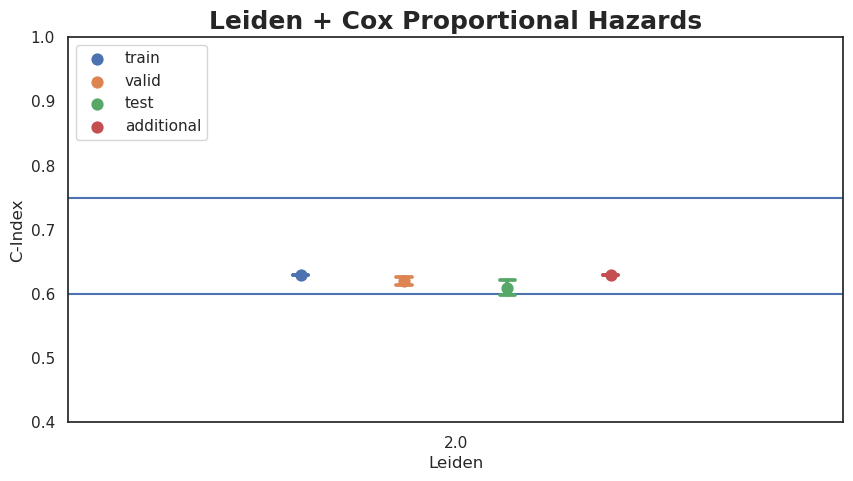

In [28]:
all_data = list()
for i, fold_data in enumerate(folds_cis):
	for c_i, set_ in fold_data:
		if c_i is None: continue
		entry = (resolution, i, c_i, set_)
		all_data.append(entry)
columns=['Leiden','Fold','C-Index','Set']
all_data = pd.DataFrame(all_data, columns=columns)

plot_performance_cindex(all_data, title='Leiden + Cox Proportional Hazards')


## Shap figures

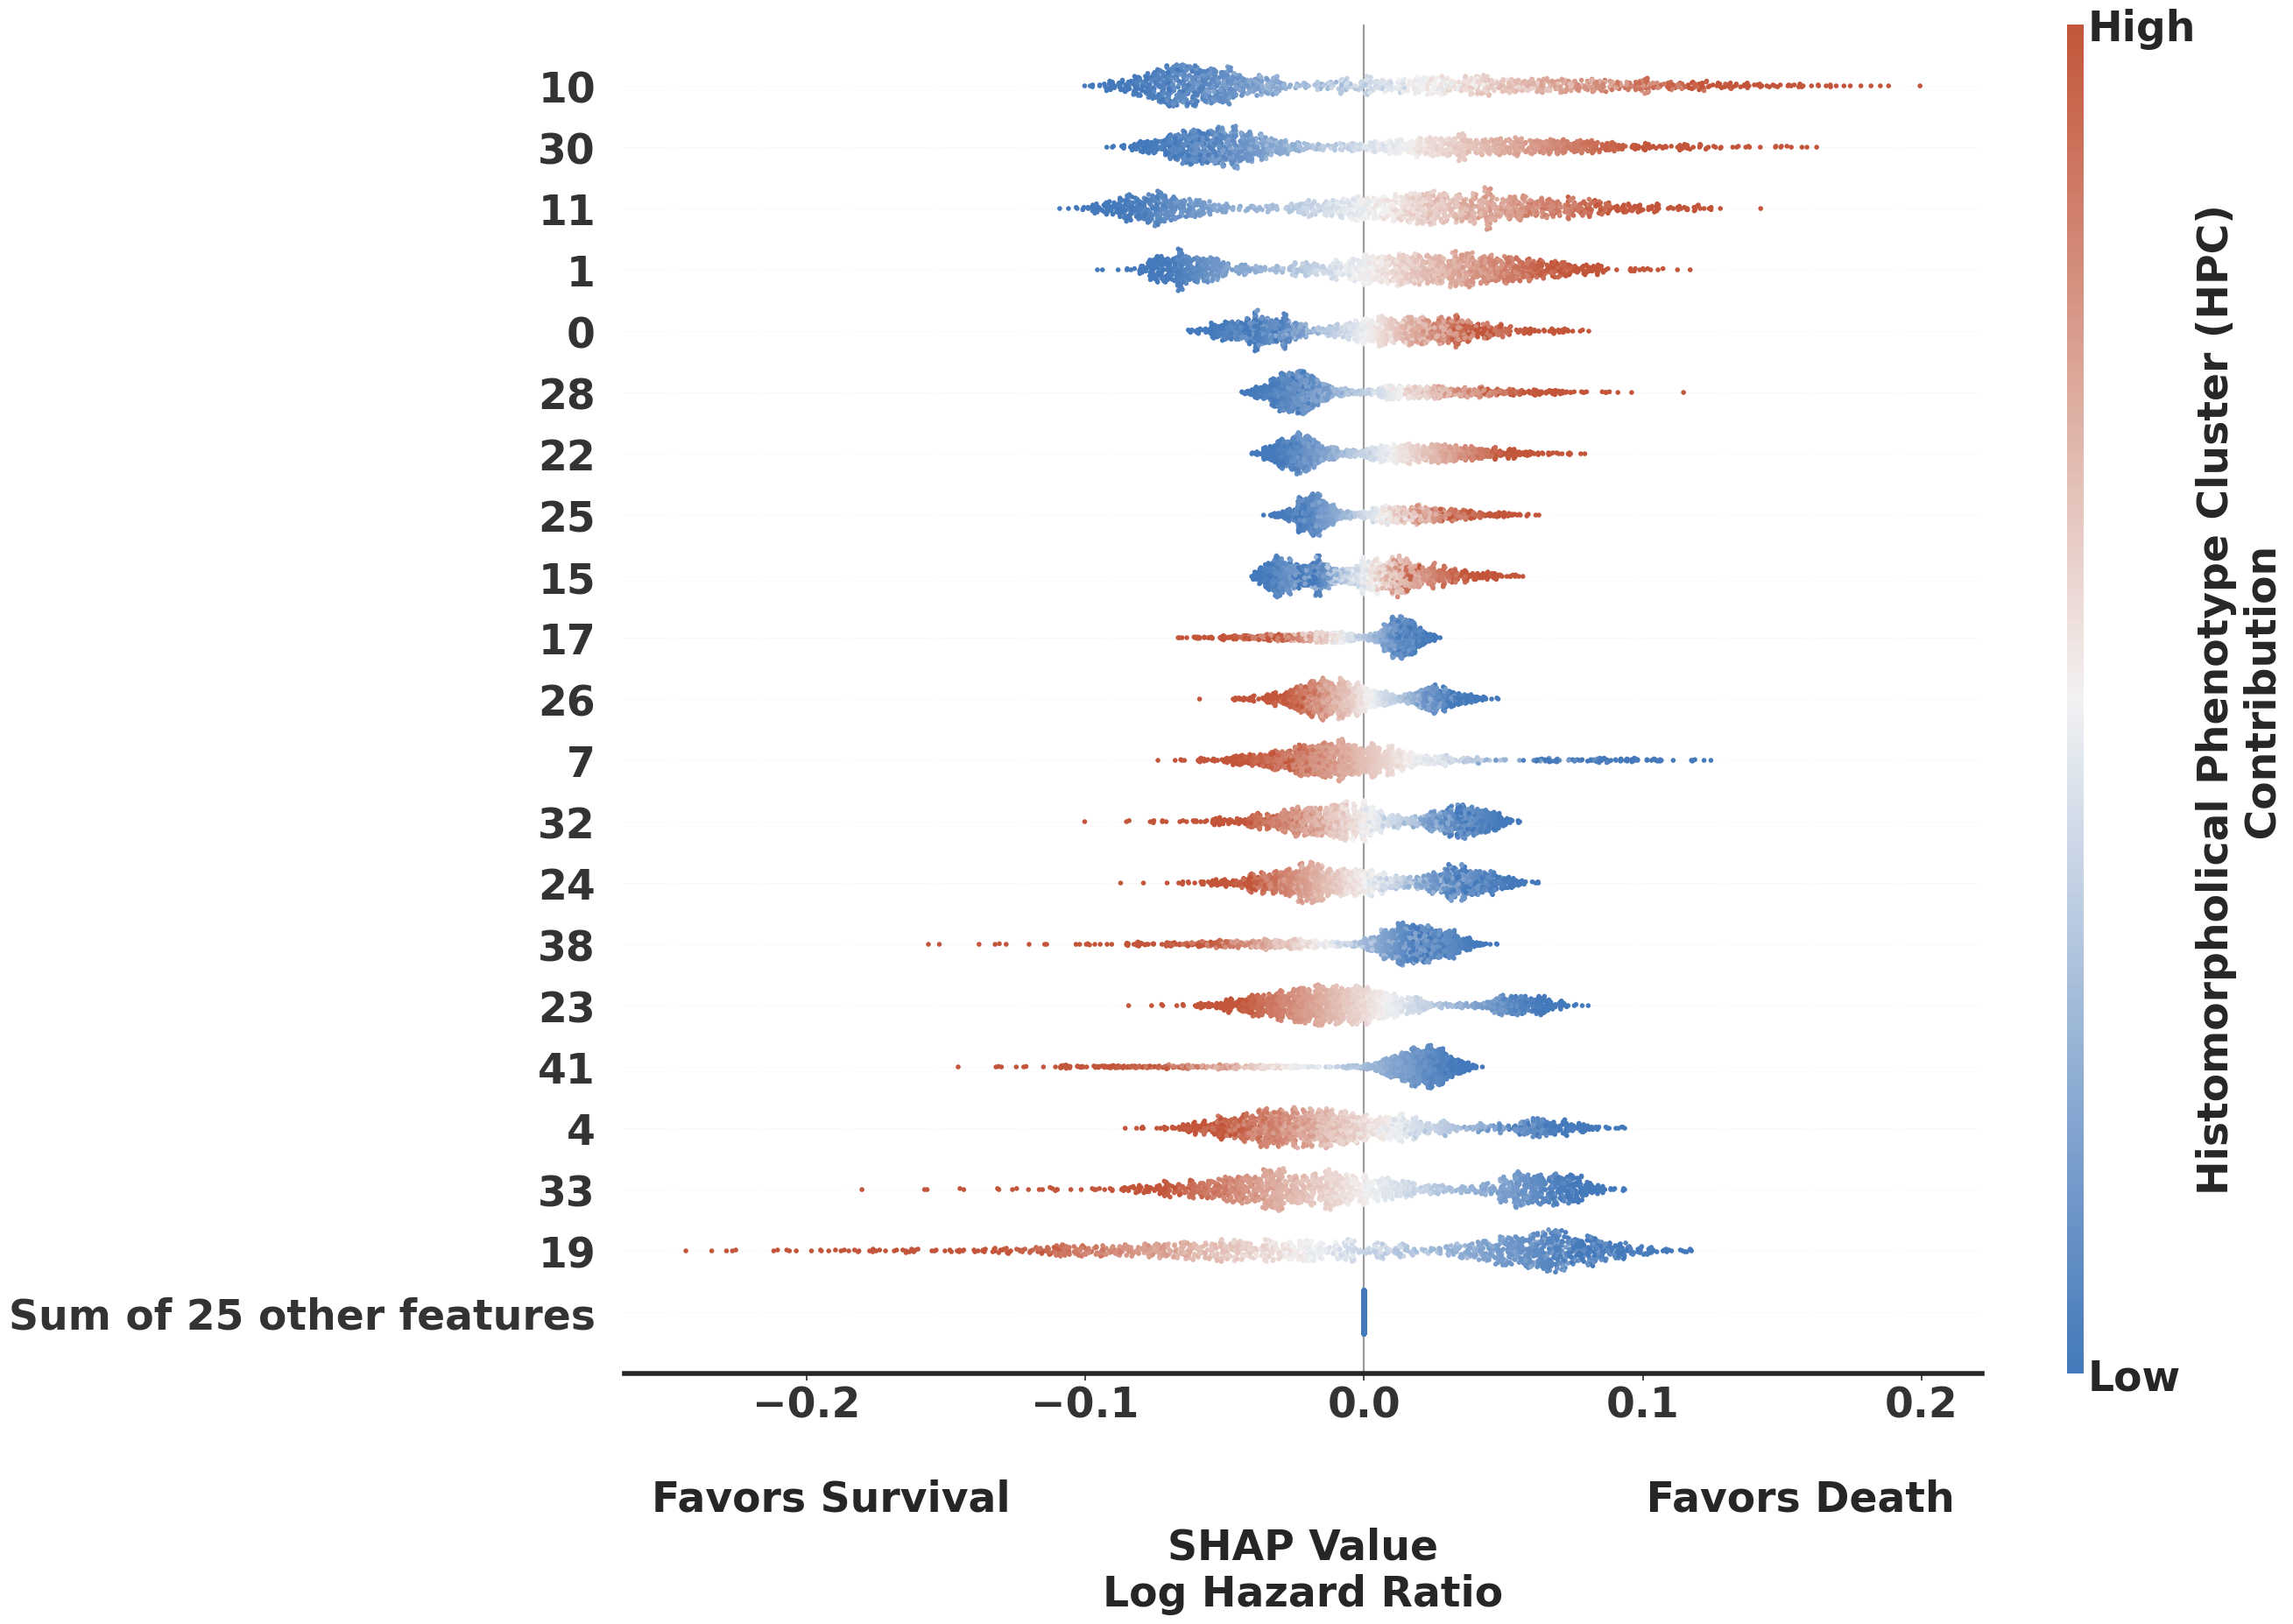

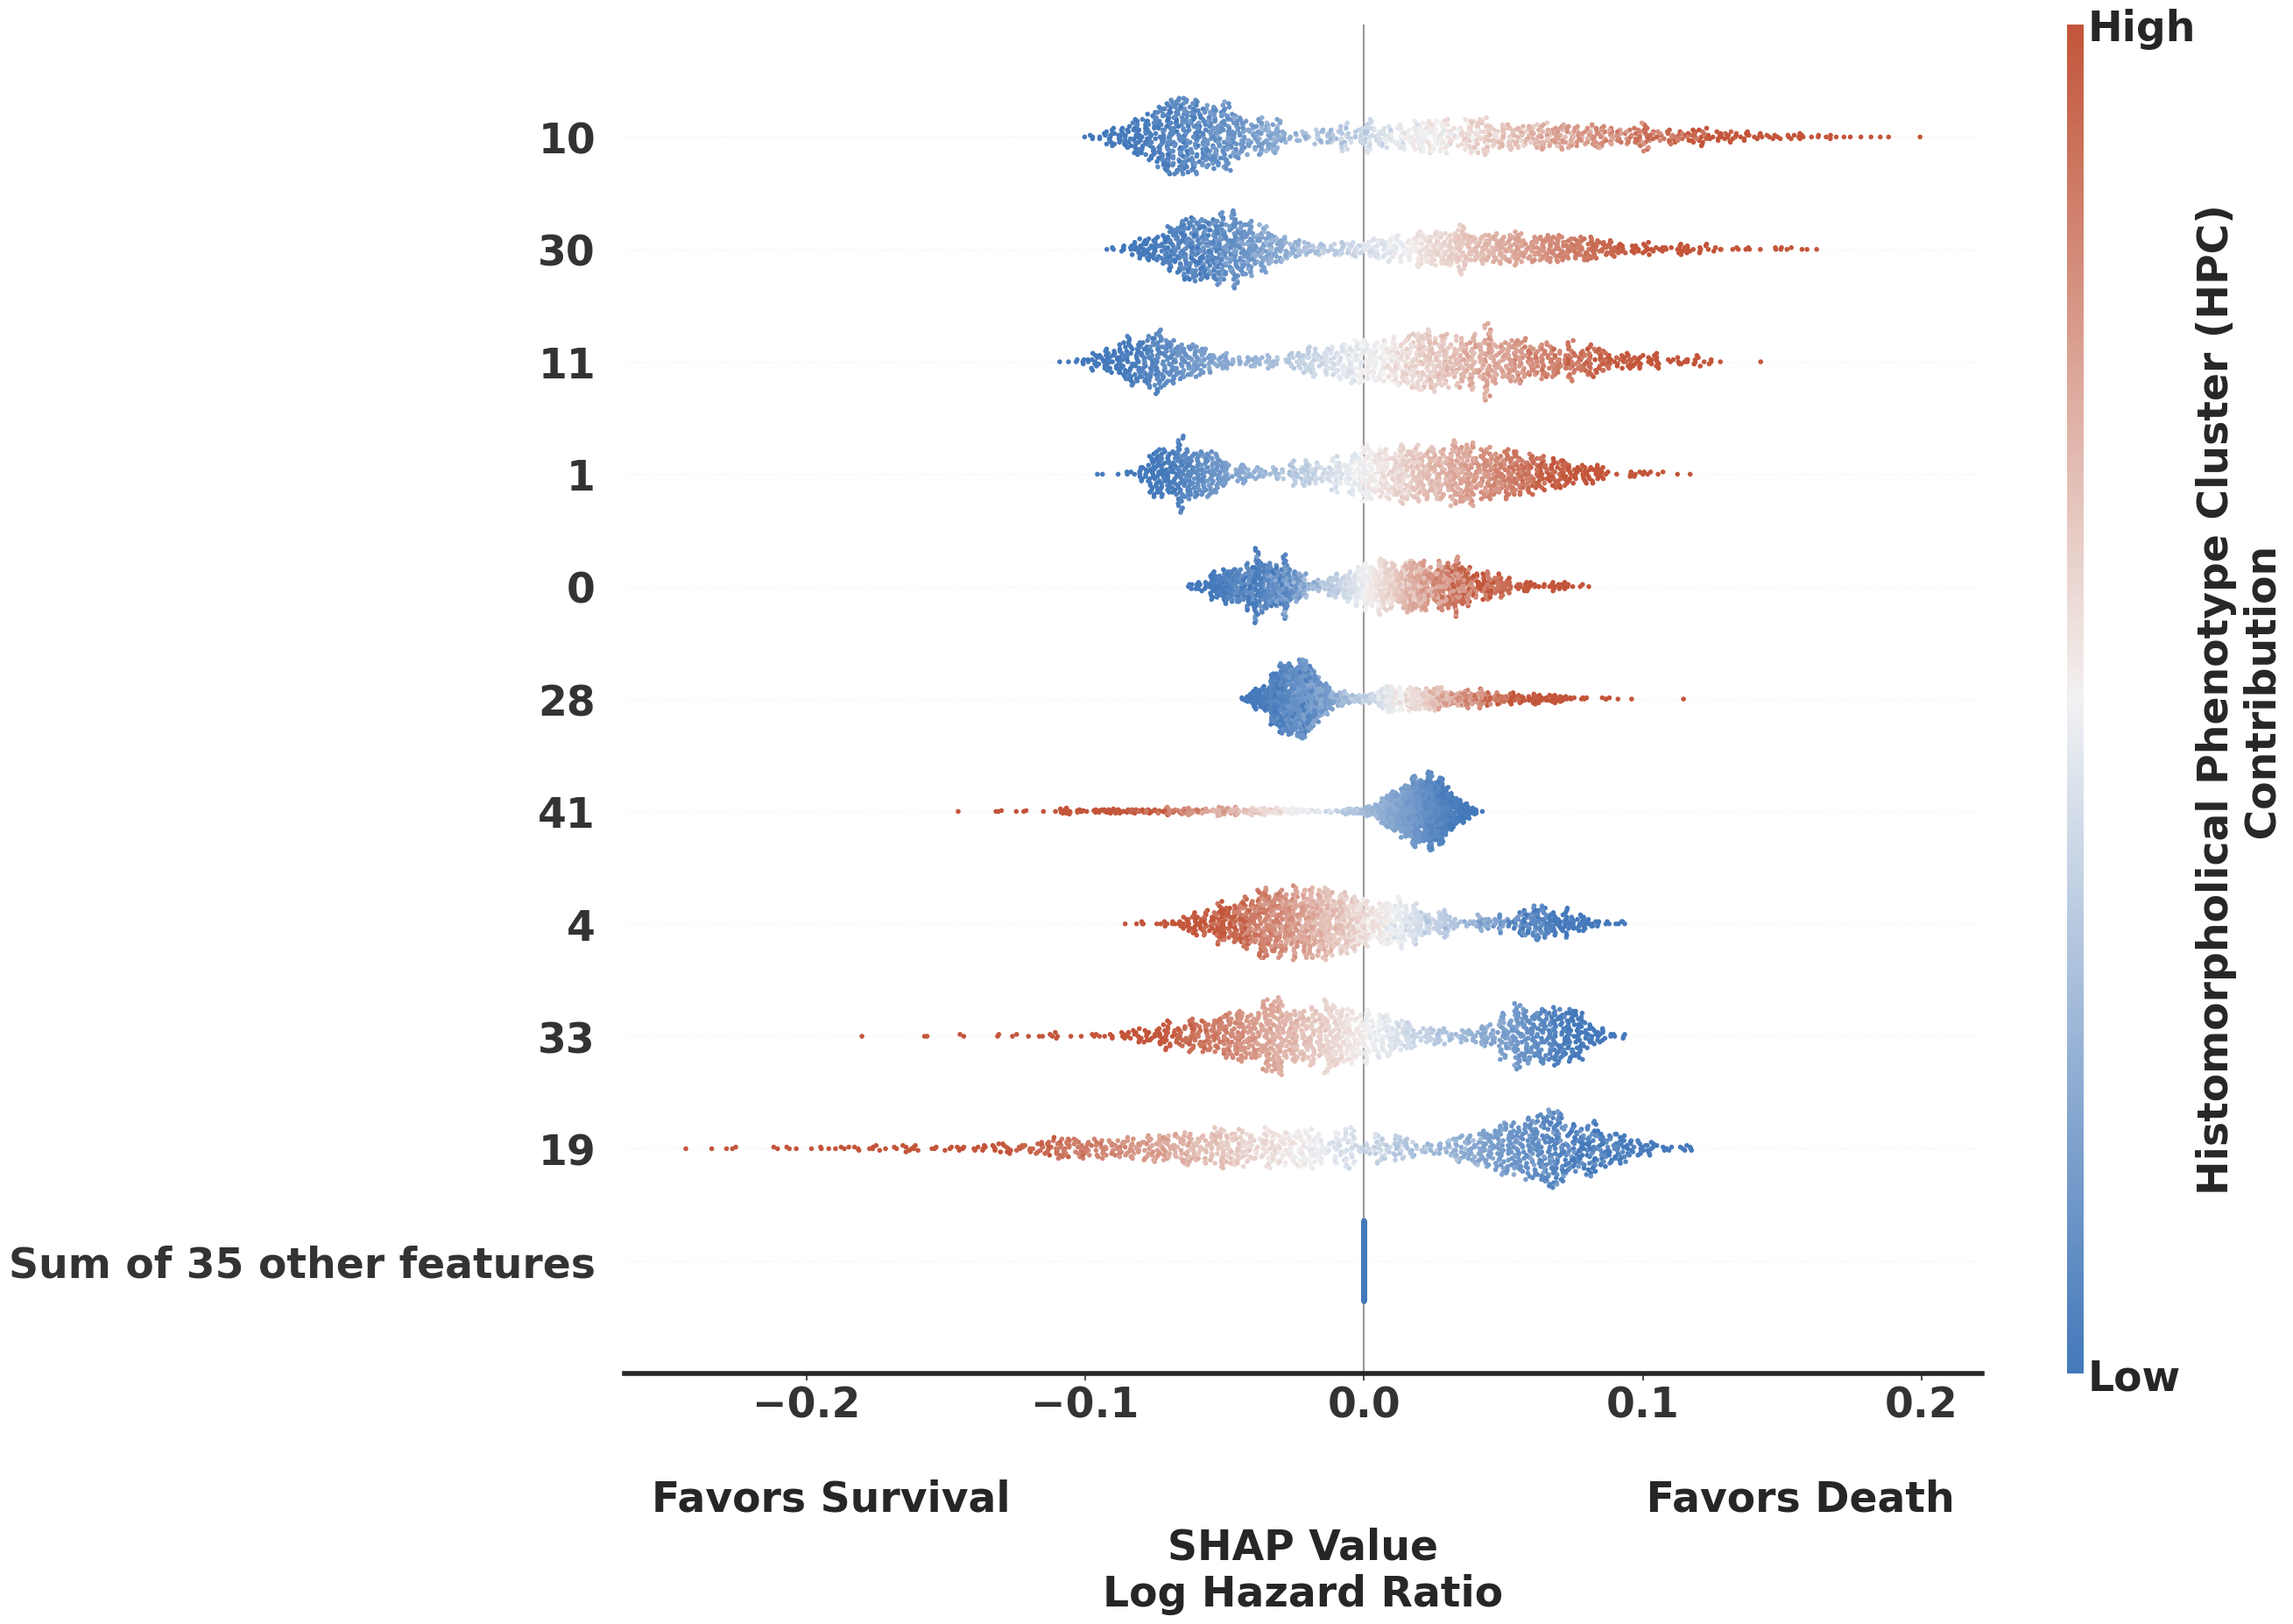

In [29]:
def remove_features_from_shap(shap_cv, features_to_remove):
	shap_cv_removed = copy.deepcopy(shap_cv)
	for feature in features_to_remove:
		shap_cv_removed.values[:,feature] = 0
		shap_cv_removed.data[:,feature] = 0
	return shap_cv_removed

for hpc_samples in [20, 10]:
	# Get order to display:
	# 1. Pro/Against event: Cox coefficient sign.
	# 2. Average absolute effect on the cohort: SHAP.
	# Select top X HPC impact for Pro/Against.
	hpc_impact = list(reversed(np.argsort(shap_cv.abs.mean(0).values)))
	pos_order = list()
	neg_order = list()
	for hpc in hpc_impact:
		if hpc in hpc_pos and len(pos_order+neg_order) < hpc_samples:
			pos_order.append(hpc)
		elif hpc in hpc_neg and len(pos_order+neg_order) < hpc_samples:
			neg_order.append(hpc)
	order = pos_order + list(reversed(neg_order))
	difference = list(set(features).difference(set(order)))
	total_order = order + list(difference)

	# Remove the features that are not going to be plotted for ascetics.
	shap_cv_removed = remove_features_from_shap(shap_cv=shap_cv, features_to_remove=difference)

	# Shap figure.
	if 'os_' in event_ind_field:
		text1 = '\nFavors Survival'
		text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
	else:
		text1 = '\nAgainst Recurrence'
		text2 = 'Favors Recurrence\nSHAP Value\nLog Hazard Ratio'

	fontsize_labels = 34
	fontsize_ticks  = 34
	plot_shap_figure(shap_cv_removed, order, total_order, text1, text2, plot_size=(25,20), fontsize_labels=fontsize_labels, fontsize_ticks=fontsize_ticks, 
					 offset=100, cmap_bar=sns.diverging_palette(250, 20, as_cmap=True))

In [37]:
data_df_perc = pd.concat([datas_all_percent[0][0], datas_all_percent[2][0]])
data_df_perc.columns = data_df_perc.columns.astype(str)
if data_df_perc.shape[0]!=dataset_samples.shape[0]:
    print(data_df_perc.shape[0])
    print(dataset_samples.shape[0])
    print('Error number of samples does not match.')

data_df_perc = data_df_perc.set_index('samples')
data_df_perc = data_df_perc.reindex(dataset_samples.samples.tolist())
data_df_perc = data_df_perc.reset_index()

num_features    = 'all'
# num_features    = 15
num_samples     = 10
fontsize_labels = 20
fontsize_ticks  = 18
fontsize_legend = 16
l_box_w         = 3
offset=75
show_legend = True

# Shap figure.
if 'os_' in event_ind_field:
    text1 = '\nFavors Survival'
    text2 = 'Favors Death\nSHAP Value\nLog Hazard Ratio'
else:
    text1 = '\nAgainst Recurrence'
    text2 = 'Favors Recurrence\nSHAP Value\nLog Hazard Ratio'
text = text1 + ''.join([' ']*(offset-len(text1+text2))) + text2

low_risk = risk_groups[0]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[:num_samples]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_low_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)]

high_risk = risk_groups[1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[:num_samples]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_high_risk)]

shap_base_values         = shap_cv.base_values
shap_values              = shap_cv.values
dataset_samples_features = dataset_samples[leiden_clusters.astype(str)]

xlim = plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w)


1506
1252
Error number of samples does not match.


KeyError: "None of ['samples'] are in the columns"

In [42]:
dataset_samples
data_df_perc
datas_all_percent[0][0]

,slides,os_event_data,os_event_ind,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,MESO_411_5,4.0,1,0.054622,0.193277,0.008403,0.033613,0.067227,0.084034,0.000000,...,0.016807,0.016807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,MESO_472_31,4.0,1,0.078261,0.052174,0.017391,0.060870,0.000000,0.000000,0.252174,...,0.017391,0.017391,0.026087,0.078261,0.008696,0.000000,0.026087,0.034783,0.000000,0.0
2,MESO_38_13,5.0,1,0.427184,0.009709,0.029126,0.000000,0.019417,0.000000,0.000000,...,0.004854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029126,0.0
3,MESO_464_9,4.0,1,0.000000,0.051793,0.019920,0.000000,0.003984,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003984,0.000000,0.000000,0.000000,0.0
4,MESO_372_6,25.0,1,0.000000,0.045226,0.005025,0.025126,0.035176,0.015075,0.000000,...,0.010050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070352,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,MESO_297_17,23.0,1,0.000000,0.059701,0.009950,0.049751,0.009950,0.024876,0.000000,...,0.029851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1261,MESO_63_2,15.0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.028481,0.262658,...,0.006329,0.003165,0.626582,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.0
1262,MESO_428_15,24.0,1,0.036260,0.043893,0.009542,0.001908,0.024809,0.055344,0.091603,...,0.001908,0.001908,0.059160,0.000000,0.000000,0.005725,0.005725,0.013359,0.022901,0.0
1263,MESO_386_22_2,8.0,1,0.271978,0.054945,0.030220,0.065934,0.000000,0.000000,0.000000,...,0.002747,0.000000,0.000000,0.000000,0.000000,0.002747,0.000000,0.000000,0.002747,0.0


In [32]:
show_legend = True
num_samples = 47

# ascending = False
# match = 0
# name_plot = 'censored_long_followup'

ascending = True
match = 1
name_plot = 'event_short_time'

dataset_samples_copy = dataset_samples.sort_values(by=event_data_field, ascending=ascending).copy(deep=True)
dataset_samples_copy = dataset_samples_copy[dataset_samples_copy[event_ind_field]==match]
samples_to_get       = dataset_samples_copy.iloc[:num_samples]['samples']

low_risk = risk_groups[0]
low_risk        = low_risk[low_risk[matching_field].isin(samples_to_get)]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[:num_samples]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_low_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)]

high_risk = risk_groups[1]
high_risk        = high_risk[high_risk[matching_field].isin(samples_to_get)]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[:num_samples]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
data_df_perc_sample = data_df_perc[data_df_perc[matching_field].isin(sample_high_risk)]

shap_base_values         = shap_cv.base_values
shap_values              = shap_cv.values
dataset_samples_features = dataset_samples[leiden_clusters.astype(str)]

plot_shap_decision(shap_base_values, shap_values, dataset_samples_features, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim)
dataset_samples_copy[dataset_samples_copy[matching_field].isin(samples_to_get)]

KeyError: 'samples'

In [33]:
combined_df = pd.DataFrame()
for hpc in leiden_clusters.astype(str):
    hpc_list = list()
    for line_a, line_b in zip(dataset_samples[hpc].values, data_df_perc[hpc].values):
        line = str(np.round(line_a,3)) + ' / ' + str(np.round(line_b*100,2))
        hpc_list.append(line)
    combined_df[hpc] = hpc_list
combined_df.columns = leiden_clusters.astype(str)
combined_df = combined_df.set_index(dataset_samples.index)
combined_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.987 / 5.46,0.888 / 19.33,2.68 / 0.84,-1.709 / 3.36,-1.709 / 6.72,-1.709 / 8.4,-1.709 / 0.0,-1.709 / 5.04,3.085 / 0.0,1.581 / 0.0,...,-1.709 / 1.68,-1.709 / 1.68,-1.709 / 0.0,-1.709 / 0.0,-1.709 / 0.0,1.581 / 0.0,-1.709 / 0.0,-1.709 / 0.0,-1.709 / 0.0,-1.709 / 0.0
1,-1.647 / 7.83,2.895 / 5.22,-1.647 / 1.74,1.643 / 6.09,2.741 / 0.0,3.994 / 0.0,2.336 / 25.22,2.336 / 0.87,-1.647 / 0.87,-1.647 / 1.74,...,0.95 / 1.74,4.476 / 1.74,-1.647 / 2.61,0.95 / 7.83,2.048 / 0.87,-1.647 / 0.0,-1.647 / 2.61,-1.647 / 3.48,-1.647 / 0.0,0.95 / 0.0
2,1.035 / 42.72,1.035 / 0.97,1.44 / 2.91,1.035 / 0.0,0.341 / 1.94,1.035 / 0.0,3.56 / 0.0,2.906 / 3.4,-2.405 / 0.97,0.341 / 0.97,...,2.287 / 0.49,-2.405 / 0.0,3.56 / 0.0,-2.405 / 0.0,-2.405 / 0.0,1.44 / 0.0,2.539 / 0.0,1.951 / 0.0,-2.405 / 2.91,-2.405 / 0.0
3,1.535 / 0.0,4.425 / 5.18,2.046 / 1.99,0.436 / 0.0,0.436 / 0.4,2.046 / 0.0,-2.099 / 0.0,1.823 / 1.59,-2.099 / 5.18,-2.099 / 0.0,...,0.436 / 0.0,0.436 / 0.0,-2.099 / 0.0,-2.099 / 0.0,-2.099 / 0.0,-2.099 / 0.4,-2.099 / 0.0,-2.099 / 0.0,-2.099 / 0.0,-2.099 / 0.0
4,1.73 / 0.0,3.435 / 4.52,1.037 / 0.5,2.136 / 2.51,2.136 / 3.52,-1.882 / 1.51,-1.882 / 0.0,2.423 / 0.0,-1.882 / 0.0,-1.882 / 0.5,...,1.037 / 1.01,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 0.0,-1.882 / 7.04,-1.882 / 0.0


In [34]:
def plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, low_risk_ind, high_risk_ind, num_features, show_legend, text, fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim=None, annotation=False, y_perc=False):

    if low_risk_ind is None:
        risk_ind = high_risk_ind
    elif high_risk_ind is None:
        risk_ind = low_risk_ind
    else:
        risk_ind = np.concatenate([low_risk_ind.values, high_risk_ind.values])

    # Legend handling.
    if show_legend:
        legend_labels = ['Low Risk' for s in range(low_risk_ind.values.shape[0])]
        legend_labels.extend(['High Risk' for s in range(high_risk_ind.values.shape[0])])
    else:
        legend_labels = None
    # Number of HPCs to display
    if num_features == 'all':
        feature_display_range = slice(None, None, -1)
    else:
        feature_display_range = slice(-1, -num_features, -1)

    shap_base_plot = [shap_base_values[risk_ind[0]]]
    shap_cv_values = np.array(shap_cv.values[risk_ind[0]].reshape((1,-1)))
    data_values    = np.array(dataset_samples_features.loc[risk_ind[0]].values.reshape((1,-1)))

    for ind in risk_ind[1:]:        
        shap_base_plot.append(shap_base_values[ind])
        shap_cv_values = np.concatenate([shap_cv_values, shap_cv.values[ind].reshape((1,-1))])
        data_values    = np.concatenate([data_values, dataset_samples_features.loc[ind].values.reshape((1,-1))])

    # SHAP decision plot.
    if not annotation:
        shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, feature_names=leiden_clusters.astype(str), xlim=xlim,
                        feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')
    else:
        shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, features=dataset_samples_features.loc[risk_ind], xlim=xlim,
                        feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')
    # shap.decision_plot(base_value=np.mean(shap_base_plot), shap_values=shap_cv_values, xlim=xlim,
                    # feature_order='importance', feature_display_range=feature_display_range, show=False, legend_labels=legend_labels, legend_location='lower right')

    # Ascetic fixes.
    figure = plt.gcf()
    figure.axes[0].set_xlabel(text, fontweight='bold', fontsize=fontsize_labels)
    if y_perc:
        figure.axes[0].set_ylabel('HPC Percentage', fontweight='bold', fontsize=fontsize_labels)
    else:
        figure.axes[0].set_ylabel('Histomorpholical Phenotype Cluster (HPC)', fontweight='bold', fontsize=fontsize_labels)

    if y_perc:
        yticklabels = list()
        for label_tick in figure.axes[0].get_yticklabels():
            hpc = label_tick._text
            anno = dataset_samples_features.loc[risk_ind, hpc].values[0]
            yticklabels.append(str(anno).split('/')[1]+'%')
        # plot.set_xticks([mini, self.center, maxi], fontsize=fontsize)
        figure.axes[0].set_yticklabels(yticklabels)
    for ax in [figure.axes[0]]:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)            
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
            tick.label2.set_fontweight('bold')
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label2.set_fontsize(fontsize_ticks)
            # if fontscale_anno == 0.0:
            # print(tick.label1)
            # print(tick.label2)
        for axis in ['bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
    
    # Legend for High/Low risk group.
    if show_legend:
        legend = figure.axes[0].legend_
        new_handles = [legend.legendHandles[0], legend.legendHandles[-1]]
        new_texts   = [legend.get_texts()[0]._text, legend.get_texts()[-1]._text]
        map_dict = dict()
        for handle, text in zip(legend.legendHandles, legend.get_texts()):
            map_dict[handle._label] = text._text

        legend.remove()
        legend = figure.axes[0].legend(new_handles, new_texts, loc='lower right')
        legend.get_frame().set_linewidth(l_box_w)
        for i, handler in enumerate(legend.legendHandles):
            handler.set_linewidth(5)
            handler.set_color('Blue')
            if i!=0:
                handler.set_color('Red')

        for text in legend.get_texts():
            text.set_size(fontsize_legend)
            text.set_fontweight('bold')

        # Re-color lines for High/Low risk group.
        continuous_lines = [child for child in figure.axes[0]._children if child._linestyle == '-' and len(child._x) > 2]
        i = 0 
        for child in continuous_lines:
            risk_name = map_dict[child._label]
            if risk_name == 'Low Risk':
                child.set_color('Blue')
            elif risk_name == 'High Risk':
                child.set_color('Red')
            i+=1
    else:
        annotations_val  = [child for child in figure.axes[0]._children if not isinstance(child, matplotlib.lines.Line2D)]
        for child in annotations_val:
            orig_fontsize = child._fontproperties._size
            child.set_fontweight('bold')
            child.set_size(orig_fontsize*1.1)

    plt.show()

    global_xlim = figure.axes[0].get_xlim()
    return global_xlim

In [35]:
high_risk = risk_groups[1]
high_risk = high_risk[high_risk.h_bin==1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[[1]]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index
dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)]


KeyError: 'samples'

In [36]:
show_legend = False

low_risk = risk_groups[0]
low_risk = low_risk[low_risk.h_bin==0]
sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[0]['samples']
low_risk_ind = dataset_samples[dataset_samples[matching_field].isin([sample_low_risk])].index


high_risk = risk_groups[1]
high_risk = high_risk[high_risk.h_bin==1]
sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[[1]]['samples']
high_risk_ind = dataset_samples[dataset_samples[matching_field].isin(sample_high_risk)].index

for l_ind, h_ind in [(low_risk_ind, None), (None, high_risk_ind)]:
    # for values_to_use in [combined_df, data_df_perc, dataset_samples]:
    for values_to_use in [combined_df]:

        shap_base_values         = shap_cv.base_values
        shap_values              = shap_cv.values
        dataset_samples_features = values_to_use[leiden_clusters.astype(str)]

        plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, l_ind, h_ind, num_features, show_legend, text, 
                               fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim, annotation=False, y_perc=False)
        plot_shap_decision_ind(shap_base_values, shap_values, dataset_samples_features, leiden_clusters, l_ind, h_ind, num_features, show_legend, text, 
                               fontsize_labels, fontsize_ticks, fontsize_legend, l_box_w, xlim, annotation=False, y_perc=True)


KeyError: 'samples'

In [30]:
from skbio.stats.composition import clr, ilr, alr, multiplicative_replacement

from scipy.stats.mstats import gmean

for ind in [0,1,2,3]:
    
    sample_low_risk = low_risk.sort_values(by=['hazard']).iloc[[ind]]['samples']
    sample_high_risk = high_risk.sort_values(by=['hazard'], ascending=False).iloc[[ind]]['samples']

    original_rep_h = data_df_perc[data_df_perc[matching_field].isin(sample_high_risk)][leiden_clusters.astype(str)].values[0,:].tolist()
    multrepl_rep_h = multiplicative_replacement(np.reshape(original_rep_h, (1,-1)))
    clr_rep_h      = clr(np.reshape(multrepl_rep_h, (1,-1)))

    delta_h = np.round(1/(multrepl_rep_h.shape[0]*multrepl_rep_h.shape[0]), 4)
    g_x_h   = np.round(gmean(multrepl_rep_h), 4)

    original_rep_l = data_df_perc[data_df_perc[matching_field].isin(sample_low_risk)][leiden_clusters.astype(str)].values[0,:].tolist()
    multrepl_rep_l = multiplicative_replacement(np.reshape(original_rep_l, (1,-1)))
    clr_rep_l      = clr(np.reshape(multrepl_rep_l, (1,-1)))

    delta_l = np.round(1/(multrepl_rep_l.shape[0]*multrepl_rep_l.shape[0]),4)
    g_x_l   = np.round(gmean(multrepl_rep_l), 4)


    fig   = plt.figure(figsize=(30,17))

    ax    = fig.add_subplot(3, 2, 1)
    ax.set_title('%s - High Risk\nCompositional Data Original' % sample_high_risk.values[0])
    ax.bar(x=leiden_clusters.tolist(), height=original_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])
    ax    = fig.add_subplot(3, 2, 2)
    ax.set_title('%s - Low Risk\nCompositional Data Original' % sample_low_risk.values[0])
    ax.bar(x=leiden_clusters.tolist(), height=original_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])

    ax    = fig.add_subplot(3, 2, 3)
    ax.set_title('Compositional Data Multiplicative Replacement\ndelta=1/N^2=%s' % delta_h)
    ax.bar(x=leiden_clusters.tolist(), height=multrepl_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])
    ax    = fig.add_subplot(3, 2, 4)
    ax.set_title('Compositional Data Multiplicative Replacement\ndelta=1/N^2=%s' % delta_l)
    ax.bar(x=leiden_clusters.tolist(), height=multrepl_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([0.0,0.9])

    ax    = fig.add_subplot(3, 2, 5)
    ax.set_title('Euclidean Data Centered Log Ratio\ng(x)=%s' % g_x_h)
    ax.bar(x=leiden_clusters.tolist(), height=clr_rep_h, tick_label=leiden_clusters)
    ax.set_ylim([-2.5,7])
    ax    = fig.add_subplot(3, 2, 6)
    ax.set_title('Euclidean Data Centered Log Ratio\ng(x)=%s' % g_x_l)
    ax.bar(x=leiden_clusters.tolist(), height=clr_rep_l, tick_label=leiden_clusters)
    ax.set_ylim([-2.5,7])

    plt.show()

NameError: name 'low_risk' is not defined